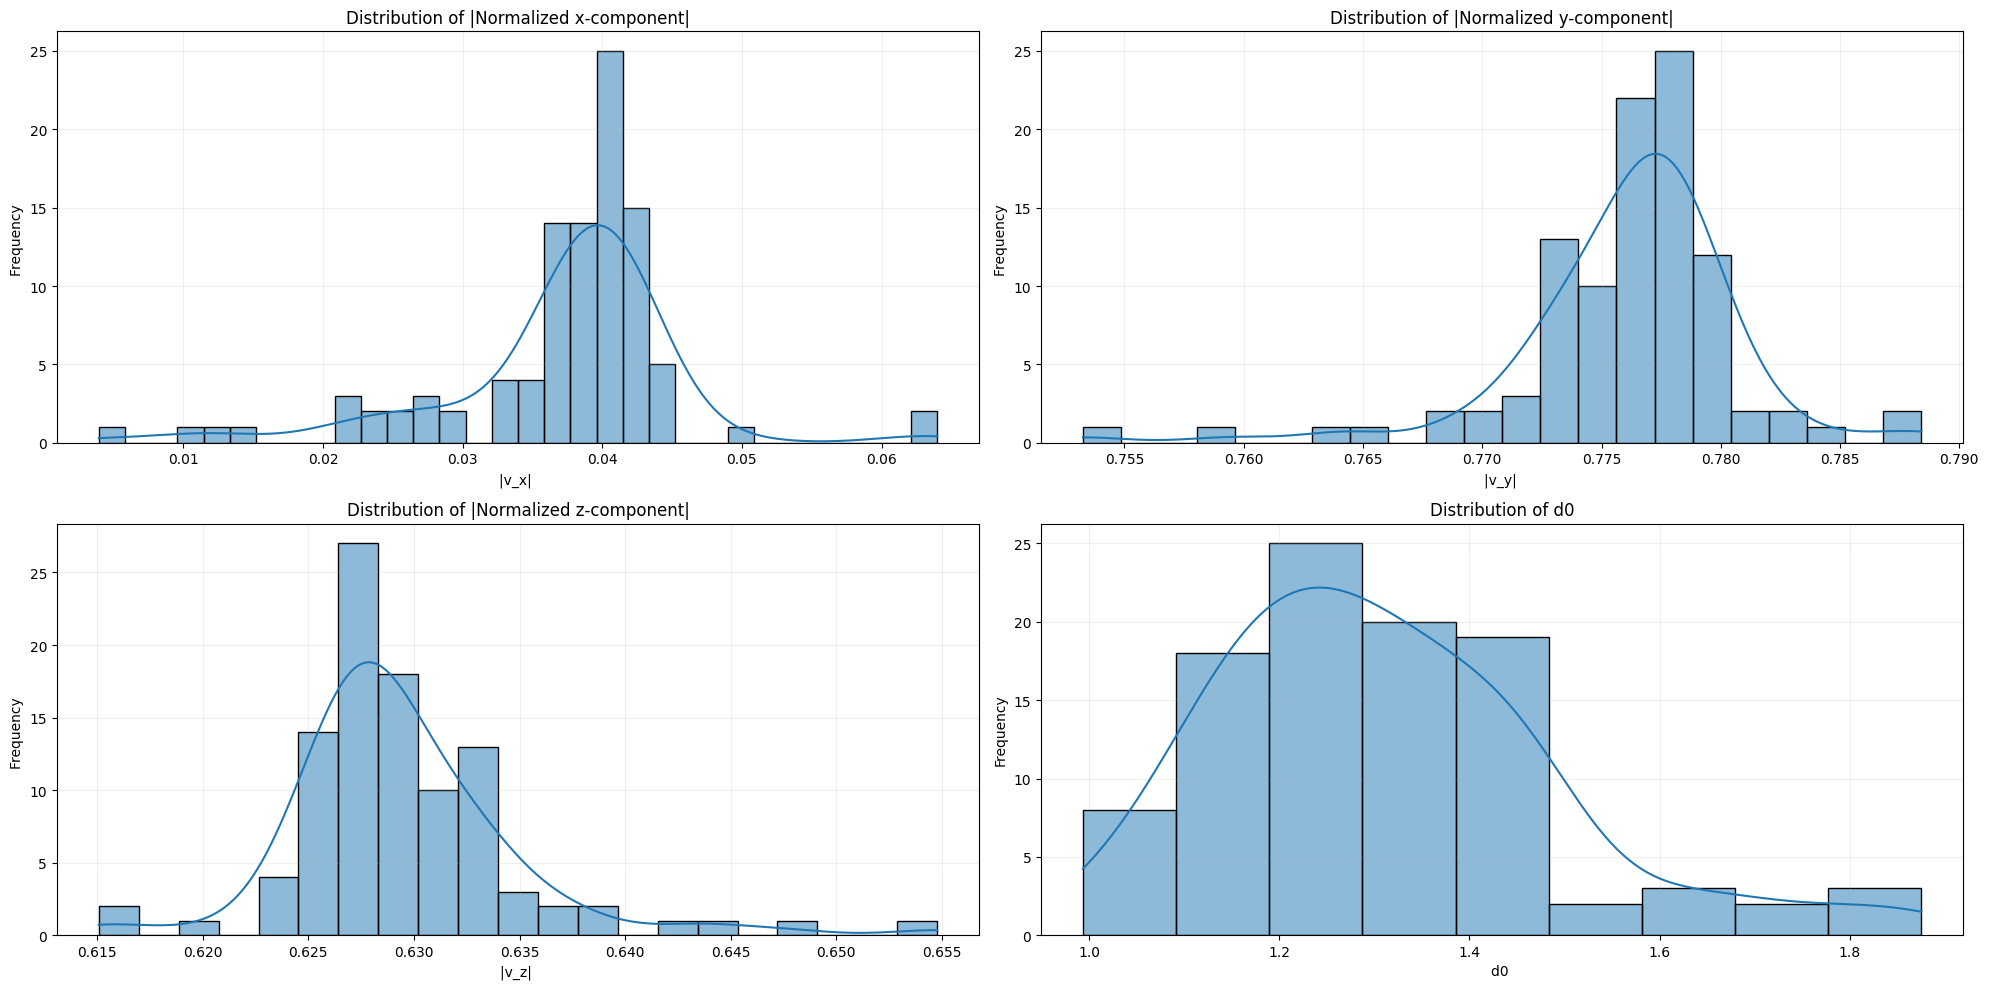

Basic Statistics for normalized vector components:
--------------------------------------------------

Component x:
Mean: 0.0371
Std: 0.0086
Min: 0.0039
Max: 0.0640

Component y:
Mean: 0.7761
Std: 0.0047
Min: 0.7533
Max: 0.7884

Component z:
Mean: -0.6294
Std: 0.0054
Min: -0.6548
Max: -0.6151

Basic Statistics for absolute values of normalized vector components:
--------------------------------------------------

|Component x|:
Mean: 0.0371
Std: 0.0086
Min: 0.0039
Max: 0.0640

|Component y|:
Mean: 0.7761
Std: 0.0047
Min: 0.7533
Max: 0.7884

|Component z|:
Mean: 0.6294
Std: 0.0054
Min: 0.6151
Max: 0.6548

Basic Statistics for d0:
--------------------------------------------------
Mean: 1.3104
Std: 0.1777
Min: 0.9934
Max: 1.8753

Verification of normalization:
Mean norm: 1.000000
Std of norms: 0.000000
Min norm: 1.000000
Max norm: 1.000000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the plane parameters
data_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/plane_fitting_results/numpy_data/all_plane_params.npy'
plane_params = np.load(data_path)

# Extract v0 = (a, b, c)
v0 = plane_params[:, :3]

# Calculate |v0| for each plane
v0_norms = np.sqrt(np.sum(v0**2, axis=1))

# Calculate normalized vectors v = v0/|v0|
v = v0 / v0_norms[:, np.newaxis]

# Calculate d0
d0_values = np.abs(plane_params[:, 3]) / v0_norms

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()
component_names = ['x', 'y', 'z']

# Create histograms for each component
for i in range(3):
    # Use absolute values for log scale
    abs_values = np.abs(v[:, i])
    sns.histplot(data=abs_values, ax=axes[i], kde=True, log_scale=(False, False))
    axes[i].set_title(f'Distribution of |Normalized {component_names[i]}-component|')
    axes[i].set_xlabel(f'|v_{component_names[i]}| ')
    axes[i].set_ylabel('Frequency ')
    axes[i].grid(True, which="both", ls="-", alpha=0.2)

# Create histogram for d0
sns.histplot(data=d0_values, ax=axes[3], kde=True, log_scale=(False, False))
axes[3].set_title('Distribution of d0')
axes[3].set_xlabel('d0 ')
axes[3].set_ylabel('Frequency')
axes[3].grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.savefig('normalized_components_and_d0_histograms_log_log.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics for each component
print("Basic Statistics for normalized vector components:")
print("-" * 50)
for i in range(3):
    print(f"\nComponent {component_names[i]}:")
    print(f"Mean: {np.mean(v[:, i]):.4f}")
    print(f"Std: {np.std(v[:, i]):.4f}")
    print(f"Min: {np.min(v[:, i]):.4f}")
    print(f"Max: {np.max(v[:, i]):.4f}")

# Print statistics for absolute values
print("\nBasic Statistics for absolute values of normalized vector components:")
print("-" * 50)
for i in range(3):
    abs_values = np.abs(v[:, i])
    print(f"\n|Component {component_names[i]}|:")
    print(f"Mean: {np.mean(abs_values):.4f}")
    print(f"Std: {np.std(abs_values):.4f}")
    print(f"Min: {np.min(abs_values):.4f}")
    print(f"Max: {np.max(abs_values):.4f}")

# Print statistics for d0
print("\nBasic Statistics for d0:")
print("-" * 50)
print(f"Mean: {np.mean(d0_values):.4f}")
print(f"Std: {np.std(d0_values):.4f}")
print(f"Min: {np.min(d0_values):.4f}")
print(f"Max: {np.max(d0_values):.4f}")

# Verify that vectors are normalized
norms = np.sqrt(np.sum(v**2, axis=1))
print("\nVerification of normalization:")
print(f"Mean norm: {np.mean(norms):.6f}")
print(f"Std of norms: {np.std(norms):.6f}")
print(f"Min norm: {np.min(norms):.6f}")
print(f"Max norm: {np.max(norms):.6f}")

In [ ]:
import numpy as np
import open3d as o3d
import cv2
import yaml

# Load plane parameters
plane_mean = np.load('plane_mean.npy')
print("Loaded plane parameters:", plane_mean)

# Load camera parameters
with open('/media/hdd_4/PhD/T4/embedded system/fp/experiment1/camera_params.yaml', 'r') as f:
    camera_params = yaml.safe_load(f)

# Load RGB and depth images
rgb_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/rgb/rgb002000.png'
depth_path = '/media/hdd_4/PhD/T4/embedded system/fp/experiment1/depth/depth_002000.png'

rgb = cv2.imread(rgb_path)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)

# Create point cloud from depth image
def create_point_cloud(rgb, depth, camera_params):
    # Get camera parameters (using depth camera parameters)
    fx = camera_params['d435_depth']['fx']
    fy = camera_params['d435_depth']['fy']
    cx = camera_params['d435_depth']['cx']
    cy = camera_params['d435_depth']['cy']
    
    # Create meshgrid of pixel coordinates
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Convert to 3D points
    z = depth.astype(float) / 1000.0  # Convert to meters
    x = (c - cx) * z / fx
    y = (r - cy) * z / fy
    
    # Stack coordinates and reshape
    points = np.stack([x, y, z], axis=-1)
    points = points.reshape(-1, 3)
    colors = rgb.reshape(-1, 3) / 255.0
    
    # Remove invalid points (where depth is 0)
    valid_points = z.reshape(-1) > 0
    points = points[valid_points]
    colors = colors[valid_points]
    
    return points, colors

# Create point cloud
points, colors = create_point_cloud(rgb, depth, camera_params)

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Create plane geometry
def create_plane_geometry(plane_params, size=2.0):
    # Extract plane parameters
    a, b, c = plane_params
    d = 0  # Assuming the plane passes through origin
    
    # Create a grid of points
    x = np.linspace(-size, size, 20)
    y = np.linspace(-size, size, 20)
    X, Y = np.meshgrid(x, y)
    
    # Calculate Z values
    Z = -(a*X + b*Y + d) / c
    
    # Create vertices
    vertices = np.stack([X.flatten(), Y.flatten(), Z.flatten()], axis=1)
    
    # Create triangles
    triangles = []
    for i in range(19):
        for j in range(19):
            v0 = i * 20 + j
            v1 = v0 + 1
            v2 = v0 + 20
            v3 = v2 + 1
            triangles.extend([[v0, v1, v2], [v1, v3, v2]])
    
    # Create mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()
    
    return mesh

# Create and visualize plane
plane_mesh = create_plane_geometry(plane_mean)

# Create coordinate frame
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.5,  # Size of the coordinate frame
    origin=[0, 0, 0]  # Origin point
)

# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add geometries
vis.add_geometry(pcd)
vis.add_geometry(plane_mesh)
vis.add_geometry(coordinate_frame)

# Set up camera
ctr = vis.get_view_control()
ctr.set_zoom(0.8)
ctr.set_front([0, 0, -1])
ctr.set_lookat([0, 0, 0])
ctr.set_up([0, -1, 0])

# Run visualization
vis.run()
vis.destroy_window()

Loaded plane parameters: [ 0.03713292  0.7761131  -0.6294009 ]



Applying 3-sigma cut to each component:
--------------------------------------------------

Component x:
Mean: 0.0371
Std: 0.0086
3-sigma range: [0.0200, 0.0543]
Values outside range: 6

Component y:
Mean: 0.7761
Std: 0.0047
3-sigma range: [0.7668, 0.7855]
Values outside range: 6

Component z:
Mean: -0.6294
Std: 0.0054
3-sigma range: [-0.6402, -0.6186]
Values outside range: 6

D0:
Mean: 1.3104
Std: 0.1777
3-sigma range: [0.9550, 1.6658]
Values outside range: 5

Total number of points before filtering: 100
Total number of points after filtering: 90
Percentage of points removed: 10.00%


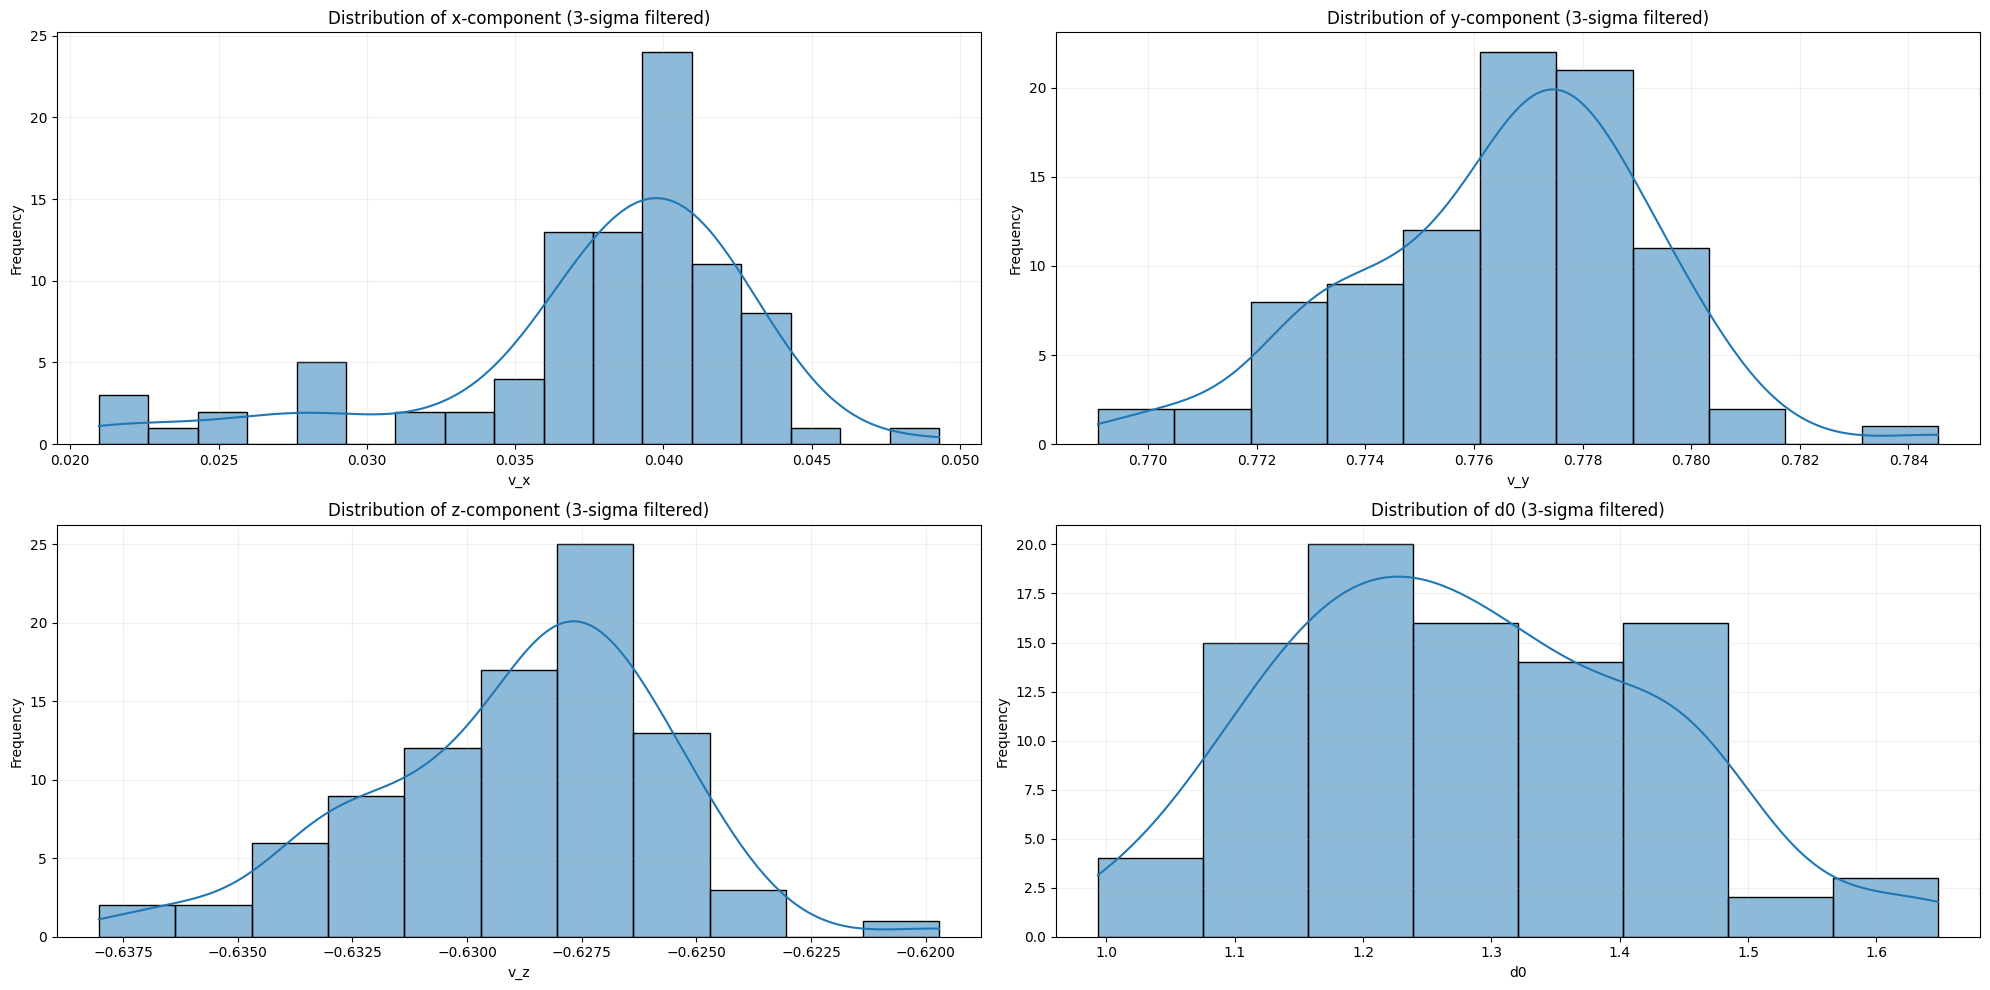

In [16]:


# Apply 3-sigma cut to each component
print("\nApplying 3-sigma cut to each component:")
print("-" * 50)

# Create arrays to store filtered data
v_filtered = np.zeros_like(v)
d0_filtered = np.zeros_like(d0_values)
valid_indices = np.ones(len(v), dtype=bool)

for i in range(3):
    mean_val = np.mean(v[:, i])
    std_val = np.std(v[:, i])
    lower_bound = mean_val - 2 * std_val
    upper_bound = mean_val + 2 * std_val
    
    # Find indices within 3-sigma range
    valid_mask = (v[:, i] >= lower_bound) & (v[:, i] <= upper_bound)
    valid_indices = valid_indices & valid_mask
    
    print(f"\nComponent {component_names[i]}:")
    print(f"Mean: {mean_val:.4f}")
    print(f"Std: {std_val:.4f}")
    print(f"3-sigma range: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"Values outside range: {np.sum(~valid_mask)}")

# Apply 3-sigma cut to d0
mean_d0 = np.mean(d0_values)
std_d0 = np.std(d0_values)
lower_bound_d0 = mean_d0 - 2 * std_d0
upper_bound_d0 = mean_d0 + 2 * std_d0
valid_mask_d0 = (d0_values >= lower_bound_d0) & (d0_values <= upper_bound_d0)
valid_indices = valid_indices & valid_mask_d0

print("\nD0:")
print(f"Mean: {mean_d0:.4f}")
print(f"Std: {std_d0:.4f}")
print(f"3-sigma range: [{lower_bound_d0:.4f}, {upper_bound_d0:.4f}]")
print(f"Values outside range: {np.sum(~valid_mask_d0)}")

# Create filtered datasets
v_filtered = v[valid_indices]
d0_filtered = d0_values[valid_indices]

print(f"\nTotal number of points before filtering: {len(v)}")
print(f"Total number of points after filtering: {np.sum(valid_indices)}")
print(f"Percentage of points removed: {(1 - np.sum(valid_indices)/len(v))*100:.2f}%")

# Create new figure with filtered data
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

# Create histograms for each component with filtered data
for i in range(3):
    sns.histplot(data=v_filtered[:, i], ax=axes[i], kde=True, log_scale=(False, False))
    axes[i].set_title(f'Distribution of {component_names[i]}-component (3-sigma filtered)')
    axes[i].set_xlabel(f'v_{component_names[i]}')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, which="both", ls="-", alpha=0.2)

# Create histogram for filtered d0
sns.histplot(data=d0_filtered, ax=axes[3], kde=True, log_scale=(False, False))
axes[3].set_title('Distribution of d0 (3-sigma filtered)')
axes[3].set_xlabel('d0')
axes[3].set_ylabel('Frequency')
axes[3].grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.savefig('filtered_components_and_d0_histograms.png', dpi=300, bbox_inches='tight')
plt.show()


Calculating statistics and applying 2-sigma cut:
--------------------------------------------------

Component x:
Mean: 0.0371
Std: 0.0086
Mode: 0.0397
2-sigma range: [0.0200, 0.0543]
Values outside range: 6

Component y:
Mean: 0.7761
Std: 0.0047
Mode: 0.7773
2-sigma range: [0.7668, 0.7855]
Values outside range: 6

Component z:
Mean: -0.6294
Std: 0.0054
Mode: -0.6279
2-sigma range: [-0.6402, -0.6186]
Values outside range: 6

D0:
Mean: 1.3104
Std: 0.1777
Mode: 1.2424
2-sigma range: [0.9550, 1.6658]
Values outside range: 5

Total number of points before filtering: 100
Total number of points after filtering: 90
Percentage of points removed: 10.00%


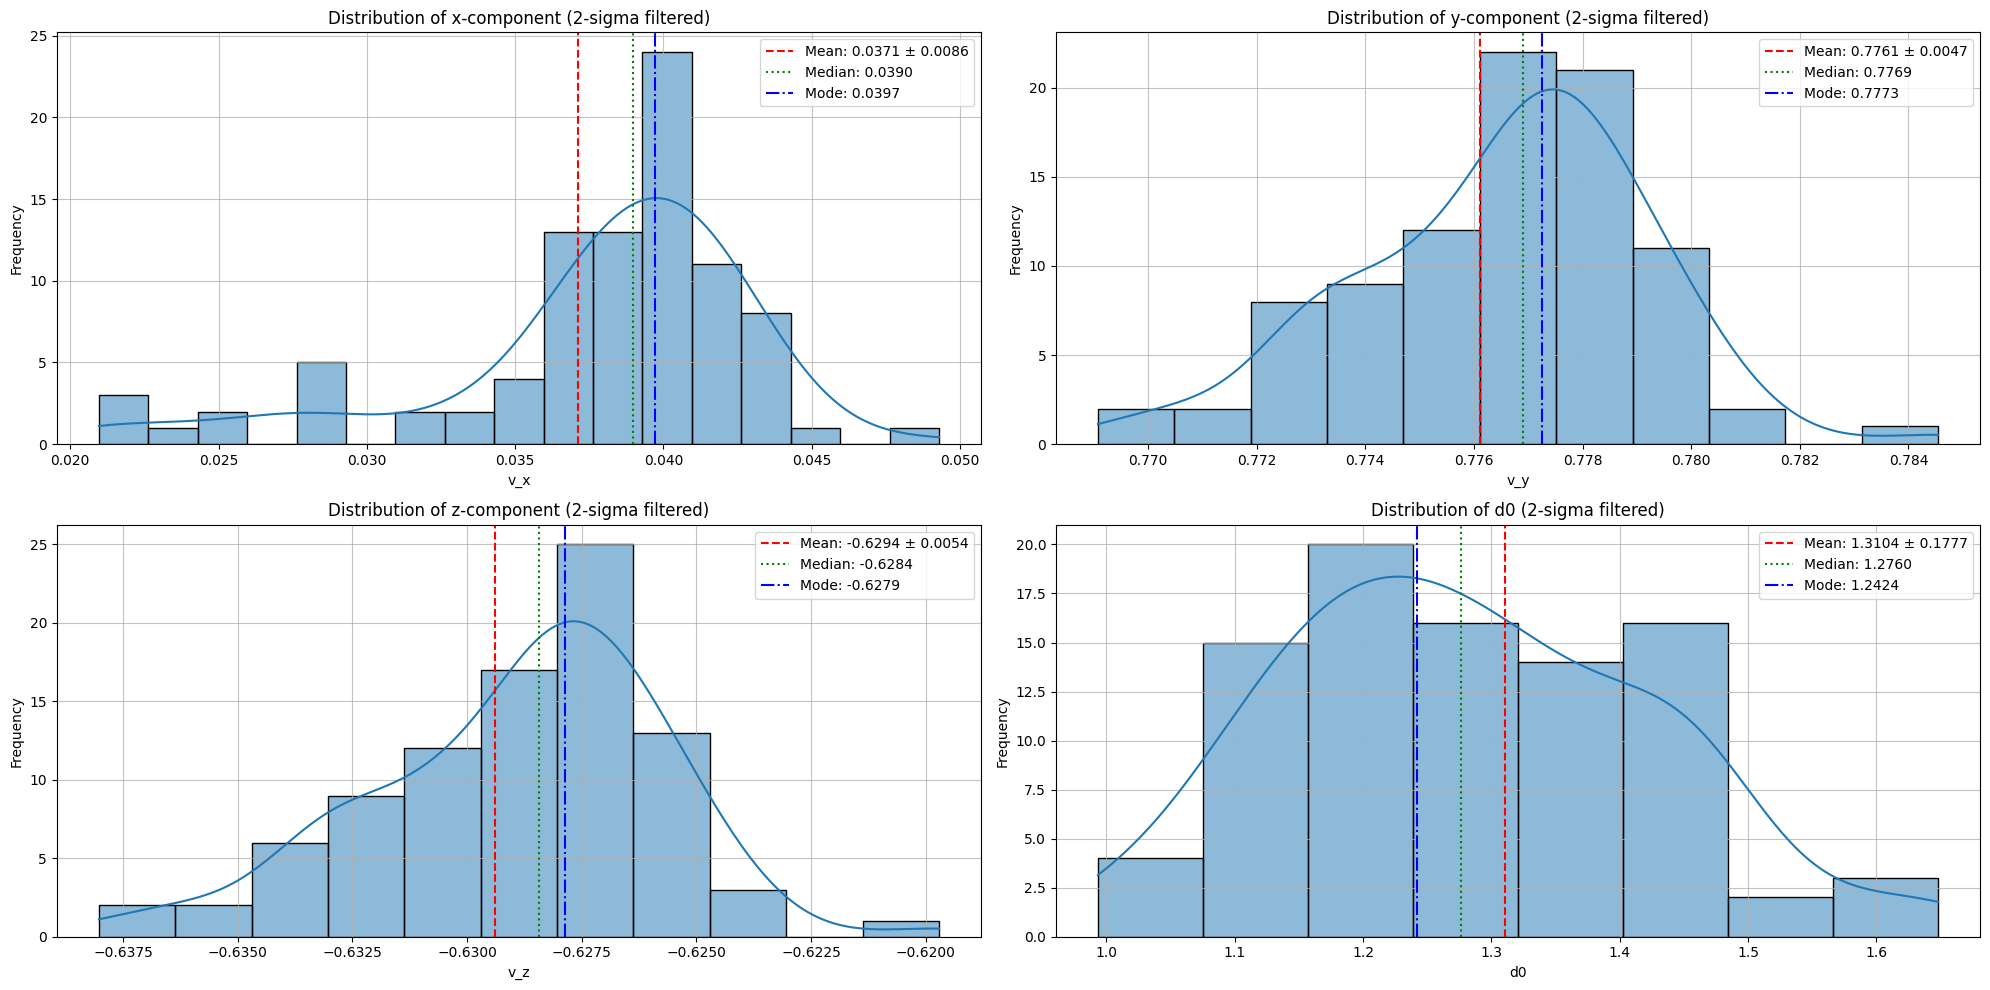


Statistics for original data:
--------------------------------------------------

Component x:
Mean: 0.0371 ± 0.0086
Median: 0.0390
Mode: 0.0397

Component y:
Mean: 0.7761 ± 0.0047
Median: 0.7769
Mode: 0.7773

Component z:
Mean: -0.6294 ± 0.0054
Median: -0.6284
Mode: -0.6279

D0:
Mean: 1.3104 ± 0.1777
Median: 1.2760
Mode: 1.2424


In [23]:
# Calculate initial statistics for each component
print("\nCalculating statistics and applying 2-sigma cut:")
print("-" * 50)

# Calculate statistics for original data
stats = {
    'v': {
        'mean': np.mean(v, axis=0),
        'median': np.median(v, axis=0),
        'std': np.std(v, axis=0),
        'mode': np.zeros(3)  # Will store mode for each component
    },
    'd0': {
        'mean': np.mean(d0_values),
        'median': np.median(d0_values),
        'std': np.std(d0_values),
        'mode': 0  # Will store mode for d0
    }
}

# Calculate modes using KDE
from scipy.stats import gaussian_kde

# Calculate mode for each component
for i in range(3):
    kde = gaussian_kde(v[:, i])
    x_range = np.linspace(min(v[:, i]), max(v[:, i]), 1000)
    density = kde(x_range)
    stats['v']['mode'][i] = x_range[np.argmax(density)]

# Calculate mode for d0
kde_d0 = gaussian_kde(d0_values)
x_range_d0 = np.linspace(min(d0_values), max(d0_values), 1000)
density_d0 = kde_d0(x_range_d0)
stats['d0']['mode'] = x_range_d0[np.argmax(density_d0)]

# Create arrays to store filtered data
v_filtered = np.zeros_like(v)
d0_filtered = np.zeros_like(d0_values)
valid_indices = np.ones(len(v), dtype=bool)

# Apply 2-sigma cut based on initial statistics
for i in range(3):
    mean_val = stats['v']['mean'][i]
    std_val = stats['v']['std'][i]
    lower_bound = mean_val - 2 * std_val
    upper_bound = mean_val + 2 * std_val
    
    # Find indices within 2-sigma range
    valid_mask = (v[:, i] >= lower_bound) & (v[:, i] <= upper_bound)
    valid_indices = valid_indices & valid_mask
    
    print(f"\nComponent {component_names[i]}:")
    print(f"Mean: {mean_val:.4f}")
    print(f"Std: {std_val:.4f}")
    print(f"Mode: {stats['v']['mode'][i]:.4f}")
    print(f"2-sigma range: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"Values outside range: {np.sum(~valid_mask)}")

# Apply 2-sigma cut to d0
mean_d0 = stats['d0']['mean']
std_d0 = stats['d0']['std']
lower_bound_d0 = mean_d0 - 2 * std_d0
upper_bound_d0 = mean_d0 + 2 * std_d0
valid_mask_d0 = (d0_values >= lower_bound_d0) & (d0_values <= upper_bound_d0)
valid_indices = valid_indices & valid_mask_d0

print("\nD0:")
print(f"Mean: {mean_d0:.4f}")
print(f"Std: {std_d0:.4f}")
print(f"Mode: {stats['d0']['mode']:.4f}")
print(f"2-sigma range: [{lower_bound_d0:.4f}, {upper_bound_d0:.4f}]")
print(f"Values outside range: {np.sum(~valid_mask_d0)}")

# Create filtered datasets
v_filtered = v[valid_indices]
d0_filtered = d0_values[valid_indices]

print(f"\nTotal number of points before filtering: {len(v)}")
print(f"Total number of points after filtering: {np.sum(valid_indices)}")
print(f"Percentage of points removed: {(1 - np.sum(valid_indices)/len(v))*100:.2f}%")

# Create new figure with filtered data
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

# Create histograms for each component with filtered data
for i in range(3):
    sns.histplot(data=v_filtered[:, i], ax=axes[i], kde=True, log_scale=(False, False))
    
    # Add vertical lines for mean, median, and mode from original statistics
    mean_val = stats['v']['mean'][i]
    median_val = stats['v']['median'][i]
    mode_val = stats['v']['mode'][i]
    std_val = stats['v']['std'][i]
    
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.4f} ± {std_val:.4f}')
    axes[i].axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.4f}')
    axes[i].axvline(mode_val, color='blue', linestyle='-.', label=f'Mode: {mode_val:.4f}')
    
    axes[i].set_title(f'Distribution of {component_names[i]}-component (2-sigma filtered)')
    axes[i].set_xlabel(f'v_{component_names[i]}')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, which="both", ls="-", alpha=0.75)
    axes[i].legend()

# Create histogram for filtered d0
sns.histplot(data=d0_filtered, ax=axes[3], kde=True, log_scale=(False, False))

# Add vertical lines for mean, median, and mode from original statistics
mean_d0 = stats['d0']['mean']
median_d0 = stats['d0']['median']
mode_d0 = stats['d0']['mode']
std_d0 = stats['d0']['std']

axes[3].axvline(mean_d0, color='red', linestyle='--', label=f'Mean: {mean_d0:.4f} ± {std_d0:.4f}')
axes[3].axvline(median_d0, color='green', linestyle=':', label=f'Median: {median_d0:.4f}')
axes[3].axvline(mode_d0, color='blue', linestyle='-.', label=f'Mode: {mode_d0:.4f}')

axes[3].set_title('Distribution of d0 (2-sigma filtered)')
axes[3].set_xlabel('d0')
axes[3].set_ylabel('Frequency')
axes[3].grid(True, which="both", ls="-", alpha=0.75)
axes[3].legend()

plt.tight_layout()
plt.savefig('filtered_components_and_d0_histograms_2sigma.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics for original data
print("\nStatistics for original data:")
print("-" * 50)
for i in range(3):
    print(f"\nComponent {component_names[i]}:")
    print(f"Mean: {stats['v']['mean'][i]:.4f} ± {stats['v']['std'][i]:.4f}")
    print(f"Median: {stats['v']['median'][i]:.4f}")
    print(f"Mode: {stats['v']['mode'][i]:.4f}")

print("\nD0:")
print(f"Mean: {stats['d0']['mean']:.4f} ± {stats['d0']['std']:.4f}")
print(f"Median: {stats['d0']['median']:.4f}")
print(f"Mode: {stats['d0']['mode']:.4f}")